Reference code - https://github.com/pdichone/advanced-rag-techniques

Udemy Certification is included in the repo

In [36]:
from helper_utils import project_embeddings, word_wrap
from pypdf import PdfReader
import os
from openai import OpenAI
from dotenv import load_dotenv

from pypdf import PdfReader
# import umap
import umap.umap_ as umap
import pandas as pd
import numpy as np
from sentence_transformers import CrossEncoder

In [2]:
# Load environment variables from .env file
load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=openai_key)


In [3]:
reader = PdfReader("data/sapphire.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]
# print(pdf_texts[:5])

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

In [4]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=0
)
character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

print(word_wrap(character_split_texts[10]))
print(f"\nTotal chunks: {len(character_split_texts)}")

• Any other documentation required by the Benefit Administrator  
to substantiate the c
laim
*Not applicable to residents in certain states
All documents must be postmarked wi
thin three hundred sixty-five (365) days of the theft or damage date, or Your claim may
 be denied.
Filing online is faster: visit www.eclaimsline.com
Transference of Claims
A
fter Your claim is paid, Your rights and remedies against any party in regard to the th
eft or damage is transferred to the Benefit Administrator, to the extent of the cost of
 payment made to You. You must give the Benefit Administrator all assistance reasonably
 required to secure all rights and remedies.
Definitions
Account  – Your credit card Ac
count issued by 
JPMorgan Chase Bank, N.A. and/or its affiliatesActual Cash Value  – th
e amount a Rental Vehicle is determined to be 
worth based on its market value, age and
 condition at the time of loss

Total chunks: 153


In [5]:
token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(word_wrap(token_split_texts[10]))
print(f"\nTotal chunks: {len(token_split_texts)}")

/Users/aditiganeshjoshi/advanced-rag-techniques-main/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


• any other documentation required by the benefit administrator to substantiate the cla
im * not applicable to residents in certain states all documents must be postmarked wit
hin three hundred sixty - five ( 365 ) days of the theft or damage date, or your claim 
may be denied. filing online is faster : visit www. eclaimsline. com transference of cl
aims after your claim is paid, your rights and remedies against any party in regard to 
the theft or damage is transferred to the benefit administrator, to the extent of the c
ost of payment made to you. you must give the benefit administrator all assistance reas
onably required to secure all rights and remedies. definitions account – your credit ca
rd account issued by jpmorgan chase bank, n. a. and / or its affiliatesactual cash valu
e – the amount a rental vehicle is determined to be worth based on its market value, ag
e and condition at the time of loss

Total chunks: 153


In [6]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

[[-0.01010268833488226, 0.08116095513105392, -0.018261486664414406, 0.017284918576478958, 0.05569984018802643, 0.03607139363884926, 0.03862407058477402, 0.08367703855037689, 0.0008984110318124294, -0.10635174065828323, 0.07421156764030457, -0.02269708178937435, 0.07979875057935715, -0.023488590493798256, 0.03787567466497421, -0.018554165959358215, 0.033249907195568085, 0.05702948570251465, 0.008307312615215778, 0.009359143674373627, -0.018351813778281212, -0.09369456768035889, -0.019834112375974655, 0.047300368547439575, 0.009967771358788013, 0.007227182388305664, -0.011849419213831425, 0.06760971248149872, 0.0073988717049360275, -0.03212699666619301, 0.05732448771595955, -0.020758016034960747, 0.12930724024772644, -0.04388413205742836, 0.08983231335878372, -0.005969107151031494, 0.0012733169132843614, 0.047445304691791534, 0.03412799537181854, -0.10219135135412216, -0.0329304113984108, -0.03368524834513664, 0.016744637861847878, -0.0911349356174469, 0.006894331891089678, -0.0039745108

In [7]:
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection(
    "qa-collection", embedding_function=embedding_function
)

# extract the embeddings of the token_split_texts
ids = [str(i) for i in range(len(token_split_texts))]
chroma_collection.add(ids=ids, documents=token_split_texts)
count = chroma_collection.count()
print(count)

153


In [8]:
query = "Until how many days does the card cover for vehicle damage? "
results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results["documents"][0]

for document in retrieved_documents:
    print(word_wrap(document))
    print("\n")

3 auto rental collision damage waiver the auto rental collision damage waiver benefit p
rovides reimbursement for damages caused by theft or collision up to the actual cash va
lue of most rented cars. the auto rental collision damage waiver acts as primary covera
ge and covers theft, damage, valid loss - of - use charges imposed and substantiated by
 the auto rental company, administrative fees, and reasonable and customary towing char
ges ( due to a covered theft or damage ) to the nearest qualified repair facility. the 
auto rental collision damage waiver covers no other type of loss. for example, in the e
vent of a collision involving your rental vehicle, damage to any other driver ’ s car, 
the injury of anyone, or damage to anything is not covered. rental periods up to thirty
 - one ( 31 ) consecutive days are covered. you are covered when your name is embossed 
on an eligible card issued in the united states, and you use your credit card account


leaving the car running and unat

In [9]:
# Generate the final answer using the OpenAI model
def generate_answer(query, context, model="gpt-3.5-turbo"):

    prompt = f"""
    You are a knowledgeable customer service agent. 
    Your users are inquiring about credit card policy details. 
    """

    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {
            "role": "user",
            "content": f"based on the following context:\n\n{context}\n\nAnswer the query: '{query}'",
        },
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content




In [10]:
df_result = pd.DataFrame()

In [11]:
# from original query
res_orig = generate_answer(query=query, context='')
print("Final Answer:")
print(res_orig)
res = pd.DataFrame({"Type": 'Original Query',"Query": query, "Context" : '', "Answer":res_orig})
df_result = pd.concat([df_result,res])


Final Answer:
["The coverage for vehicle damage provided by a credit card can vary depending on the type of card and the specific terms and conditions set by the card issuer. Generally, credit cards offer rental car insurance coverage for a limited number of days, typically up to 15 or 31 days. It's important to review your credit card's benefits guide or contact your card issuer directly to understand the exact coverage limits and conditions for vehicle damage protection."]


In [12]:
df_result = df_result.reset_index(drop=True)

In [13]:
df_result

,Type,Query,Context,Answer
0,Original Query,Until how many days does the card cover for ve...,,The coverage for vehicle damage provided by a ...


In [14]:
# basic RAG
context = "\n\n".join(retrieved_documents)
res_rag = generate_answer(query=query, context=context)
print("Final Answer:")
print(res_rag)
res = pd.DataFrame({"Type":'Basic RAG',"Query": query, "Context" : context, "Answer":res_rag})
df_result = pd.concat([df_result,res])

Final Answer:
['The auto rental collision damage waiver benefit covers theft or collision damages for up to thirty-one (31) consecutive days for rental periods.']


In [15]:
df_result = df_result.reset_index(drop=True)


In [16]:
df_result

,Type,Query,Context,Answer
0,Original Query,Until how many days does the card cover for ve...,,The coverage for vehicle damage provided by a ...
1,Basic RAG,Until how many days does the card cover for ve...,3 auto rental collision damage waiver the auto...,The auto rental collision damage waiver benefi...


### Query Expansion - Answer

In [17]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    prompt = """You are a helpful expert customer support agent. 
   Provide an example answer to the given question, that might be found in a credit card policy documentation."""
    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content


original_query = "Until how many days does the card cover for vehicle damage?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))


Until how many days does the card cover for vehicle damage? "The credit card offers cov
erage for vehicle damages up to 30 days from the date of rental when the entire cost of
 the rental transaction is charged to the card."


In [18]:
results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"][0]


for doc in retrieved_documents:
    print(word_wrap(doc))
    print("")

3 auto rental collision damage waiver the auto rental collision damage waiver benefit p
rovides reimbursement for damages caused by theft or collision up to the actual cash va
lue of most rented cars. the auto rental collision damage waiver acts as primary covera
ge and covers theft, damage, valid loss - of - use charges imposed and substantiated by
 the auto rental company, administrative fees, and reasonable and customary towing char
ges ( due to a covered theft or damage ) to the nearest qualified repair facility. the 
auto rental collision damage waiver covers no other type of loss. for example, in the e
vent of a collision involving your rental vehicle, damage to any other driver ’ s car, 
the injury of anyone, or damage to anything is not covered. rental periods up to thirty
 - one ( 31 ) consecutive days are covered. you are covered when your name is embossed 
on an eligible card issued in the united states, and you use your credit card account

regardless of who is at fault and

/Users/aditiganeshjoshi/advanced-rag-techniques-main/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


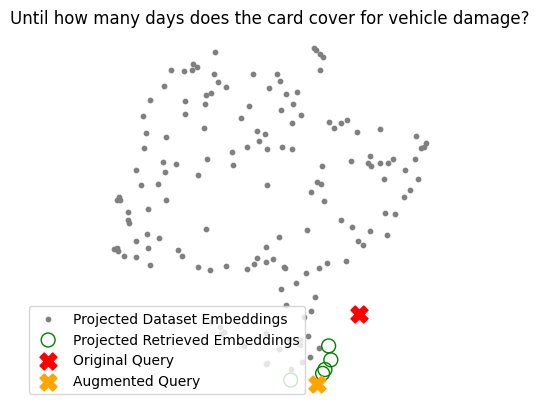

<Figure size 640x480 with 0 Axes>

In [19]:
embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)


retrieved_embeddings = results["embeddings"][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(
    original_query_embedding, umap_transform
)
projected_augmented_query_embedding = project_embeddings(
    augmented_query_embedding, umap_transform
)
projected_retrieved_embeddings = project_embeddings(
    retrieved_embeddings, umap_transform
)

import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()

plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
    label="Projected Dataset Embeddings"
)
plt.scatter(
    projected_retrieved_embeddings[:, 0],
    projected_retrieved_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
    label="Projected Retrieved Embeddings"
)
plt.scatter(
    projected_original_query_embedding[:, 0],
    projected_original_query_embedding[:, 1],
    s=150,
    marker="X",
    color="r",
    label="Original Query"
)
plt.scatter(
    projected_augmented_query_embedding[:, 0],
    projected_augmented_query_embedding[:, 1],
    s=150,
    marker="X",
    color="orange",
    label="Augmented Query"
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.legend()
plt.show()  # display the plot
plt.savefig('embeddings_and_retrieved_documents.png')

In [20]:
joint_query

'Until how many days does the card cover for vehicle damage? "The credit card offers coverage for vehicle damages up to 30 days from the date of rental when the entire cost of the rental transaction is charged to the card."'

In [21]:
# query expansion with sample answer
context = "\n\n".join(retrieved_documents)
res_rag_qea = generate_answer(query=joint_query, context=context)
print("Final Answer:")
print(res_rag_qea)
res = pd.DataFrame({"Type":'Query Expansion with Sample Answer', "Query": joint_query, "Context" : context, "Answer":res_rag_qea})
df_result = pd.concat([df_result,res])

Final Answer:
["The credit card's auto rental collision damage waiver benefit covers vehicle damages up to thirty-one (31) consecutive days from the date of rental when the entire rental transaction cost is charged to the card."]


In [22]:
df_result = df_result.reset_index(drop=True)

In [23]:
df_result

,Type,Query,Context,Answer
0,Original Query,Until how many days does the card cover for ve...,,The coverage for vehicle damage provided by a ...
1,Basic RAG,Until how many days does the card cover for ve...,3 auto rental collision damage waiver the auto...,The auto rental collision damage waiver benefi...
2,Query Expansion with Sample Answer,Until how many days does the card cover for ve...,3 auto rental collision damage waiver the auto...,The credit card's auto rental collision damage...


### Query Expansion - Generate Multiple Subqueries

In [24]:
def generate_multi_query(query, model="gpt-3.5-turbo"):

    prompt = """
    You are a knowledgeable customer service agent. 
    Your users are inquiring about credit card policy details. 
    For the given question, propose up to five related questions to assist them in finding the information they need. 
    Provide concise, single-topic questions (withouth compounding sentences) that cover various aspects of the topic. 
    Ensure each question is complete and directly related to the original inquiry. 
    List each question on a separate line without numbering.
                """

    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content


original_query = (
    "Until how many days does the card cover for vehicle damage?"
)
aug_queries = generate_multi_query(original_query)

# 1. First step show the augmented queries
for query in aug_queries:
    print("\n", query)


 1. What are the specific terms and conditions for vehicle damage coverage with the credit card?

 2. Is there a limit to the amount of coverage provided for vehicle damage by the credit card?

 3. Are there any exclusions or restrictions on the types of vehicle damage covered by the credit card?

 4. Does the credit card require any additional documentation or proof of vehicle damage to process a claim?

 5. How do I initiate the process for claiming vehicle damage coverage through the credit card?


In [25]:
joint_query = [
    original_query
] + aug_queries  # original query is in a list because chroma can actually handle multiple queries, so we add it in a list

# print("======> \n\n", joint_query)

results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"]

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {joint_query[i]}")
    print("")
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print("")
    print("-" * 100)

Query: Until how many days does the card cover for vehicle damage?

Results:
3 auto rental collision damage waiver the auto rental collision damage waiver benefit p
rovides reimbursement for damages caused by theft or collision up to the actual cash va
lue of most rented cars. the auto rental collision damage waiver acts as primary covera
ge and covers theft, damage, valid loss - of - use charges imposed and substantiated by
 the auto rental company, administrative fees, and reasonable and customary towing char
ges ( due to a covered theft or damage ) to the nearest qualified repair facility. the 
auto rental collision damage waiver covers no other type of loss. for example, in the e
vent of a collision involving your rental vehicle, damage to any other driver ’ s car, 
the injury of anyone, or damage to anything is not covered. rental periods up to thirty
 - one ( 31 ) consecutive days are covered. you are covered when your name is embossed 
on an eligible card issued in the united st

/Users/aditiganeshjoshi/advanced-rag-techniques-main/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


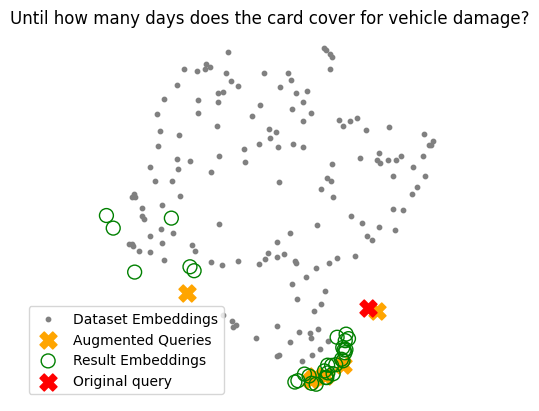

In [26]:
embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

# 4. We can also visualize the results in the embedding space
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(joint_query)


project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(
    augmented_query_embeddings, umap_transform
)

retrieved_embeddings = results["embeddings"]
result_embeddings = [item for sublist in retrieved_embeddings for item in sublist]

projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

import matplotlib.pyplot as plt


# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
    label='Dataset Embeddings'
)
plt.scatter(
    project_augmented_queries[:, 0],
    project_augmented_queries[:, 1],
    s=150,
    marker="X",
    color="orange",
    label='Augmented Queries'
)
plt.scatter(
    projected_result_embeddings[:, 0],
    projected_result_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
    label='Result Embeddings'
)
plt.scatter(
    project_original_query[:, 0],
    project_original_query[:, 1],
    s=150,
    marker="X",
    color="r",
    label='Original query'
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.legend()
plt.show()  # display the plot


In [27]:
joint_query

['Until how many days does the card cover for vehicle damage?',
 '1. What are the specific terms and conditions for vehicle damage coverage with the credit card?',
 '2. Is there a limit to the amount of coverage provided for vehicle damage by the credit card?',
 '3. Are there any exclusions or restrictions on the types of vehicle damage covered by the credit card?',
 '4. Does the credit card require any additional documentation or proof of vehicle damage to process a claim?',
 '5. How do I initiate the process for claiming vehicle damage coverage through the credit card?']

In [28]:
context = "\n\n".join(unique_documents)
res_qem = generate_answer(query=joint_query, context=context)
print("Final Answer:")
print(res_qem)

Final Answer:
['1. The credit card provides coverage for vehicle damage up to thirty-one (31) consecutive days.', '   ', '2. The specific terms and conditions for vehicle damage coverage with the credit card include reimbursement for damages caused by theft or collision up to the actual cash value of most rented cars. The coverage acts as primary coverage and covers theft, damage, valid loss-of-use charges, administrative fees, and towing charges to the nearest repair facility.', '', '3. There is no specific limit mentioned in the provided information regarding the amount of coverage provided for vehicle damage by the credit card. Coverage is provided up to the actual cash value of most rented cars.', '', '4. Exclusions or restrictions on the types of vehicle damage covered by the credit card include losses caused by intentional acts, wear and tear, gradual deterioration, mechanical breakdown, off-road operation, and damage due to hostility or illegal activities. ', '', '5. To initiate

In [29]:
print(res_qem)

['1. The credit card provides coverage for vehicle damage up to thirty-one (31) consecutive days.', '   ', '2. The specific terms and conditions for vehicle damage coverage with the credit card include reimbursement for damages caused by theft or collision up to the actual cash value of most rented cars. The coverage acts as primary coverage and covers theft, damage, valid loss-of-use charges, administrative fees, and towing charges to the nearest repair facility.', '', '3. There is no specific limit mentioned in the provided information regarding the amount of coverage provided for vehicle damage by the credit card. Coverage is provided up to the actual cash value of most rented cars.', '', '4. Exclusions or restrictions on the types of vehicle damage covered by the credit card include losses caused by intentional acts, wear and tear, gradual deterioration, mechanical breakdown, off-road operation, and damage due to hostility or illegal activities. ', '', '5. To initiate the process f

In [30]:
len(res_qem)

14

In [31]:
res = pd.DataFrame({"Type": 'Query Expansion with multiple subqueries',"Query": " ".join(joint_query), "Context" : context, "Answer":[" ".join(res_qem)]})
df_result = pd.concat([df_result,res])

In [32]:
df_result = df_result.reset_index(drop=True)
df_result

,Type,Query,Context,Answer
0,Original Query,Until how many days does the card cover for ve...,,The coverage for vehicle damage provided by a ...
1,Basic RAG,Until how many days does the card cover for ve...,3 auto rental collision damage waiver the auto...,The auto rental collision damage waiver benefi...
2,Query Expansion with Sample Answer,Until how many days does the card cover for ve...,3 auto rental collision damage waiver the auto...,The credit card's auto rental collision damage...
3,Query Expansion with multiple subqueries,Until how many days does the card cover for ve...,"4 for questions, call 1 - 888 - 320 - 9961 if ...",1. The credit card provides coverage for vehic...


In [33]:
df_result.to_csv('results.csv')

In [34]:
df_result= df_result[['Type','Query','Answer','Context']]
df_result

,Type,Query,Answer,Context
0,Original Query,Until how many days does the card cover for ve...,The coverage for vehicle damage provided by a ...,
1,Basic RAG,Until how many days does the card cover for ve...,The auto rental collision damage waiver benefi...,3 auto rental collision damage waiver the auto...
2,Query Expansion with Sample Answer,Until how many days does the card cover for ve...,The credit card's auto rental collision damage...,3 auto rental collision damage waiver the auto...
3,Query Expansion with multiple subqueries,Until how many days does the card cover for ve...,1. The credit card provides coverage for vehic...,"4 for questions, call 1 - 888 - 320 - 9961 if ..."


In [35]:
df_result.to_csv('results.csv')


### Re-ranking

In [37]:
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

/Users/aditiganeshjoshi/advanced-rag-techniques-main/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [40]:
query = "Until how many days does the card cover for vehicle damage? "
results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results["documents"][0]

for document in retrieved_documents:
    print(word_wrap(document))
    print("\n")

3 auto rental collision damage waiver the auto rental collision damage waiver benefit p
rovides reimbursement for damages caused by theft or collision up to the actual cash va
lue of most rented cars. the auto rental collision damage waiver acts as primary covera
ge and covers theft, damage, valid loss - of - use charges imposed and substantiated by
 the auto rental company, administrative fees, and reasonable and customary towing char
ges ( due to a covered theft or damage ) to the nearest qualified repair facility. the 
auto rental collision damage waiver covers no other type of loss. for example, in the e
vent of a collision involving your rental vehicle, damage to any other driver ’ s car, 
the injury of anyone, or damage to anything is not covered. rental periods up to thirty
 - one ( 31 ) consecutive days are covered. you are covered when your name is embossed 
on an eligible card issued in the united states, and you use your credit card account


leaving the car running and unat

In [41]:
pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)

In [42]:
print("Scores:")
for score in scores:
    print(score)

print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o + 1)


Scores:
3.5189843
2.194956
1.002946
-0.74049366
-6.449171
New Ordering:
1
2
3
4
5


In [46]:
original_query = (
     "Until how many days does the card cover for vehicle damage?"
)

generated_queries = [
    "What are the specific terms and conditions for vehicle damage coverage with the credit card?",

 "Is there a limit to the amount of coverage provided for vehicle damage by the credit card?",

 "Are there any exclusions or restrictions on the types of vehicle damage covered by the credit card?",

 "Does the credit card require any additional documentation or proof of vehicle damage to process a claim?",

 "How do I initiate the process for claiming vehicle damage coverage through the credit card?"
]
# concatenate the original query with the generated queries
queries = [original_query] + generated_queries
results = chroma_collection.query(
    query_texts=queries, n_results=10, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"]

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

scores = cross_encoder.predict(pairs)

print("Scores:")
for score in scores:
    print(score)

print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o)

Scores:
-10.078721
-5.467606
0.88471526
-6.449172
-8.646059
-8.949869
-2.2846386
2.194954
-7.5458736
-11.144317
-11.028517
-6.5375175
-10.75261
-9.899497
-10.644993
-5.361944
-5.925519
3.5189843
1.002947
-10.811666
-6.634488
-5.73022
-7.258842
-0.7404928
New Ordering:
17
7
18
2
23
6
15
1
21
16
3
11
20
22
8
4
5
13
0
14
12
19
10
9


In [47]:
top_indices = np.argsort(scores)[::-1][:5]
top_documents = [unique_documents[i] for i in top_indices]

# Concatenate the top documents into a single context
context = "\n\n".join(top_documents)

In [48]:
# Generate the final answer using the OpenAI model
def generate_multi_query_reranked(query, context, model="gpt-3.5-turbo"):

    prompt = f"""
    You are a knowledgeable financial research assistant. 
    Your users are inquiring about an annual report. 
    """

    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {
            "role": "user",
            "content": f"based on the following context:\n\n{context}\n\nAnswer the query: '{query}'",
        },
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content


res = generate_multi_query_reranked(query=original_query, context=context)
print("Final Answer:")
print(res)

Final Answer:
['The card covers vehicle damage up to one hundred (100) days from the date of the incident. Any theft or damage reported more than one hundred days after the incident may not be covered by the auto rental collision damage waiver benefit.']


In [49]:
res = pd.DataFrame({"Type": 'Re-ranking',"Query": " ".join(queries), "Context" : context, "Answer":[" ".join(res)]})
df_result = pd.concat([df_result,res])

In [50]:
df_result = df_result.reset_index(drop=True)
df_result

,Type,Query,Answer,Context
0,Original Query,Until how many days does the card cover for ve...,The coverage for vehicle damage provided by a ...,
1,Basic RAG,Until how many days does the card cover for ve...,The auto rental collision damage waiver benefi...,3 auto rental collision damage waiver the auto...
2,Query Expansion with Sample Answer,Until how many days does the card cover for ve...,The credit card's auto rental collision damage...,3 auto rental collision damage waiver the auto...
3,Query Expansion with multiple subqueries,Until how many days does the card cover for ve...,1. The credit card provides coverage for vehic...,"4 for questions, call 1 - 888 - 320 - 9961 if ..."
4,Re-ranking,Until how many days does the card cover for ve...,The card covers vehicle damage up to one hundr...,3 auto rental collision damage waiver the auto...


In [51]:
df_result.to_csv('results.csv')
